# Preprocessing, GridSearch and Training DenseNet-6 and DenseNet-8 on Private Data without B/W-tests

In [1]:
import numpy as np
from numpy import array
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import math

import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools
import collections
from collections import OrderedDict, Counter

import scipy.stats as stats
from scipy.stats import normaltest, kstest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, levene, bartlett
from scipy.stats import chi2_contingency, fisher_exact, mode, pearsonr, f_oneway, kruskal, spearmanr

from rfpimp import *

from datetime import datetime
import re
from seaborn import heatmap
import random
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.utils import resample
from functools import reduce
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn import metrics, preprocessing
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer

from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.multiclass import type_of_target
from sklearn.linear_model import LogisticRegression

import gc
import os

#from sklearn.externals import joblib
import joblib

from importlib import reload
import Filter_and_Grid_Search
Filter_and_Grid_Search = reload(Filter_and_Grid_Search)
from Filter_and_Grid_Search import stratified_split
from Filter_and_Grid_Search import attributes_list, attributes_list_new
from Filter_and_Grid_Search import get_s_stat, get_PSI_stat, get_stats_by_month, get_stats, stable_unstable
from Filter_and_Grid_Search import stable_unstable_by_month_divide, union_datas, individual_hists_all 
from Filter_and_Grid_Search import paired_time_hists_by_month, statistics_with_target
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import statistics_with_target, attributes_list, attributes_list_new, make_standard
from Filter_and_Grid_Search import data_preprocessing_train, data_preprocessing_test
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import stratified_split, two_forests, turn_variables_with_values
from Filter_and_Grid_Search import find_meta_params, calculate_vif#, find_meta_params_mem
from Filter_and_Grid_Search import plot_meta_2d, data_preprocessing, find_ouliers_iqr
from Filter_and_Grid_Search import train_model_receive_stats, simple_b_score_risk
from Filter_and_Grid_Search import max_prof_corve, by_month_gini, check_attribute_list_cases

from Filter_and_Grid_Search import to_zip, br_correction, br_stat

from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pathlib
import psutil

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH_DATA = 'D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/'
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_v2_2014/'
print(PATH_DATA)
print(PATH)

D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/
D:/Share/safanasev/Python-notebook/AF_ML_v2_2014/


In [3]:
for DIR in ['Data Sets', 'Documentation', 'Graphs', 'Modeling', 'SandBox', 'Selection', 'Statistics']:
    PATH_DIR = PATH + DIR
    pathlib.Path(PATH_DIR).mkdir(parents=True, exist_ok=True)
    
for DIR in ['csv_from_python', 'excel', 'python']:
    PATH_DIR = PATH + 'Selection/' + DIR
    pathlib.Path(PATH_DIR).mkdir(parents=True, exist_ok=True) 

In [4]:
#Сырые данные
train_data = 'antifraud_data_train_with_2014.csv'
test_data  = 'antifraud_data_test_with_2014.csv'
val_data   = 'antifraud_data_valid_with_2014.csv'

In [5]:
task = 'binary'
missing_strings = 'MISSING'
p_value = 0.05
target_dict = {'good': 0, 'bad': 1}

In [6]:
target = 'BAD_FLAG'
index_month = 'MONTH_YEAR'
list_of_vars_for_strat = ['MONTH_YEAR']
sort_by_var = 'APPPOSID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0', 'PERIOD_7', 'LOSS_90P'] 
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [7]:
COL_DEL

['UNNAMED: 0', 'PERIOD_7', 'LOSS_90P']

In [8]:
necessary_fields

['BAD_FLAG', 'MONTH_YEAR', 'APPPOSID']

In [9]:
n_jobs = 3

In [10]:
path_train_data = PATH_DATA  +  train_data

## Loading preprocessed data

In [11]:
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_v2_2014/'

In [12]:
target = 'BAD_FLAG'
index_month = 'MONTH_YEAR'
list_of_vars_for_strat = ['MONTH_YEAR']
sort_by_var = 'APPPOSID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0', 'PERIOD_7', 'LOSS_90P'] 
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [13]:
#загружаем данные для 163 переменных

train_for = pd.read_csv(PATH + 'train_163_prep.csv')
valid_for = pd.read_csv(PATH + 'valid_163_prep.csv')
test_for = pd.read_csv(PATH + 'test_163_prep.csv')

In [14]:
y_train = train_for[target]
#y_test = valid_for[target]
#y_val = test_for[target]

y_test = test_for[target]
y_val = valid_for[target]

train_for.drop('Unnamed: 0', axis = 1, inplace = True)
valid_for.drop('Unnamed: 0', axis = 1, inplace = True)
test_for.drop('Unnamed: 0', axis = 1, inplace = True)

col = train_for.columns.to_list()
col.remove(target)

X_1_2 = train_for[col]
X_2_2 = valid_for[col]
X_3_2 = test_for[col]

## Removing B-tests and W-tests

In [15]:
b_test = []
w_test = []
del_all = []

for i in X_2_2.columns:
    if i.find('W_TEST') >= 0:
        w_test.append(i)
        del_all.append(i)
    if i.find('B_TEST') >= 0:
        b_test.append(i)
        del_all.append(i)


In [16]:
col = train_for.columns.to_list()
col.remove(target)
col_2 = [i for i in col if i not in del_all]
X_1_2 = train_for[col_2]
X_2_2 = valid_for[col_2]
X_3_2 = test_for[col_2]


In [17]:
#проверка корректности
X_1_2.shape, train_for.shape, len(y_train)

((1507599, 124), (1507599, 164), 1507599)

In [18]:
#проверка корректности, должно быть везде True
print(X_1_2.shape[0] == train_for.shape[0])
print(len(y_train) == train_for.shape[0])

True
True


In [19]:
x_col = X_2_2.columns
y_col = 'BAD_FLAG'

# ***

## Tensorflow

In [20]:
import tensorflow as tf

In [21]:
from tensorflow.keras.layers import (Input, Activation, Dense, Flatten, Dropout)
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, AveragePooling1D)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [22]:
from tensorflow.keras.layers import ReLU, Concatenate, GlobalAveragePooling1D

In [23]:
from keras.utils import np_utils
from tensorflow.keras.models import Model

In [24]:
# Задаем seed_value для воспроизводимости
# Можно использовать разные seed_value для разных систем
seed_value= 29


# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)


# 5. Configure a new global `tensorflow` session
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler

# объявляем класс метрик

class E_time(Callback):
    def on_train_begin(self, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('train_begin', '| time: ' , tm)
        
    def on_epoch_end(self, epoch, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('epoch_end', '| time: ' , tm)
    
        return

_time = E_time()

In [26]:
#если alpha не задано, то не делаем br_correction

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,  dataset, x_col, y_col,  batch_size=256, num_classes=2, alpha = 0.1, random_state = 42, 
                 shuffle=True, class_w = None):
        self.batch_size = batch_size
        self.dataset = dataset
        self.x_col = x_col
        self.y_col = y_col
        self.indices = self.dataset.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.alpha = alpha
        self.random_state = random_state
        self.class_w = class_w
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        data_tmp = self.dataset.loc[batch]
        data_tmp_b = data_tmp[data_tmp[self.y_col] == 1]
        data_tmp_b_all = self.dataset[self.dataset[self.y_col] == 1]
        X_tmp = data_tmp.head(0)
        
        
        #print(data_tmp_b.shape[0], data_tmp.shape[0], data_tmp_b_all.shape[0])
        if (self.alpha is None) and (self.class_w is None):
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col] 
            
        elif (self.alpha is None) and self.class_w > 0:
            k = (self.class_w*self.batch_size)/(1-self.class_w)
            k = k - data_tmp_b.shape[0]
            if int(k) < 1:
                k = k+1
            ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
            X_tmp = data_tmp_b_all.iloc[ix2]
            data_tmp = data_tmp.append(X_tmp, ignore_index=True)
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]
            #print(data_tmp_b.shape[0], data_tmp.shape[0],  data_tmp_b.shape[0]/(data_tmp.shape[0] - X_tmp.shape[0]), np.mean(y)) 
            
            
            
        else:
            if data_tmp_b.shape[0] > 0:
                k=(self.alpha*self.batch_size/data_tmp_b.shape[0] -1 )/(1-self.alpha)
                for i in range(0,int(k)):
                    X_tmp = X_tmp.append(data_tmp_b, ignore_index=True)
            else:
                k = (self.alpha*self.batch_size)/(1-self.alpha)
                ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
                X_tmp = data_tmp_b_all.iloc[ix2]
                data_tmp_b = X_tmp

    #         print('Добавим дробное число строк')    
            k_fraction = k - int(k)
            n_samples = int(round(data_tmp_b.shape[0]*k_fraction))
    #         print(k_fraction, n_samples)

            ix = np.random.RandomState(self.random_state).choice(data_tmp_b.shape[0], n_samples)
            data_add_fraction = data_tmp_b.iloc[ix]
            X_tmp.append(data_add_fraction, ignore_index=True)

            data_tmp = data_tmp.append(X_tmp, ignore_index=True)


            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]   
        
        if self.num_classes > 1:
            y = np_utils.to_categorical( y, self.num_classes)
            
        return [np.array(X)], np.array(y)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

In [27]:
# здесь батчсайз надо указывать тот, который получился по гридсерч сетке
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.05)

In [28]:
Y_test_2 = np_utils.to_categorical(y_val, 2) # преобразовываем в 2 класса 

In [29]:
sum(y_train)/y_train.shape[0]

0.00278190685984801

In [30]:
Y_test_2.shape, X_2_2.shape

((185400, 2), (185400, 124))

# ***

# DenseNet 1D

In [31]:
import tensorflow
from tensorflow.keras.layers import BatchNormalization, Activation, Conv1D, Concatenate, AveragePooling1D

In [32]:
# функции для 1D-DenseNet
# надо по гридсерч сетке подобрать параметры:
# 1) k (количетсво фильтров): сделать параметры адекватные для 1D (по умолчанию стоят от 2D)
# 2) kernel_width (размер фильтра/свертки): сделать параметры адекватные для 1D (по умолчанию стоят от 2D)
# 3) bottleneck_size - это мультпликатор для кол-ва фильтров k.
# 4) num_layers - количество сверток в денз-блоке (нужно 3 и 4 - соотвествует спайдеру/2)

""" 
blocks/one_d.py
Author: Ankit Gupta

Implementations of various DenseNet blocks for 1D sequences

This module contains helper functions that define the various subcomponents of a DenseNet. 
This includes dense blocks and transition blocks.

"""

#from tf.keras.layers import BatchNormalization, Activation, Conv1D, Concatenate, AveragePooling1D


def H_l(k, bottleneck_size, kernel_width):
    """ 
    A single convolutional "layer" as defined by Huang et al. Defined as H_l in the original paper
    
    :param k: int representing the "growth rate" of the DenseNet
    :param bottleneck_size: int representing the size of the bottleneck, as a multiple of k. 
    Set to 0 for no bottleneck.
    :param kernel_width: int representing the width of the main convolutional kernel
    :return a function wrapping the keras layers for H_l
    """

    use_bottleneck = bottleneck_size > 0
    num_bottleneck_output_filters = k * bottleneck_size

    def f(x):
        if use_bottleneck:
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv1D(
                num_bottleneck_output_filters,
                1,
                strides=1,
                padding="same",
                dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv1D(
            k,
            kernel_width,
            strides=1,
            padding="same",
            dilation_rate=1)(x)
        return x
    return f


def dense_block(k, num_layers, kernel_width, bottleneck_size):
    """
    A single dense block of the DenseNet
    
    :param k: int representing the "growth rate" of the DenseNet
    :param num_layers: int represending the number of layers in the block
    :param kernel_width: int representing the width of the main convolutional kernel
    :param bottleneck_size: int representing the size of the bottleneck, as a multiple of k. Set to 0 for no bottleneck.
    :return a function wrapping the entire dense block
    """
    def f(x):
        layers_to_concat = [x]
        for _ in range(num_layers):
            x = H_l(k, bottleneck_size, kernel_width)(x)
            layers_to_concat.append(x)
            x = Concatenate(axis=-1)(layers_to_concat)
        return x
    return f


def transition_block(pool_size=2, stride=2, theta=0.5):
    """
    A single transition block of the DenseNet
    
    :param pool_size: int represending the width of the average pool
    :param stride: int represending the stride of the average pool
    :param theta: int representing the amount of compression in the 1x1 convolution. Set to 1 for no compression.
    :return a function wrapping the entire transition block
    """    
    assert theta > 0 and theta <= 1

    def f(x):
        num_transition_output_filters = int(int(x.shape[2]) * float(theta))
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv1D(
            num_transition_output_filters,
            1,
            strides=1,
            padding="same",
            dilation_rate=1)(x)
        x = AveragePooling1D(
            pool_size=pool_size,
            strides=stride,
            padding="same")(x)
        return x
    return f


def DenseNet_1(
        k,
        block_sizes,
        conv_kernel_width,
        bottleneck_size,
        transition_pool_size,
        transition_pool_stride,
        theta,
        initial_conv_width,
        initial_stride,
        initial_filters,
        initial_pool_width,
        initial_pool_stride,
        use_global_pooling):
    def f(x):
        x = Conv1D(
            initial_filters,
            initial_conv_width,
            strides=initial_stride,
            padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling1D(
            pool_size=initial_pool_width,
            strides=initial_pool_stride,
            padding="same")(x)

        # Add all but the last dense block
        for block_size in block_sizes[:-1]:
            x = dense_block(
                k,
                block_size,
                conv_kernel_width,
                bottleneck_size)(x)
            x = transition_block(
                pool_size=transition_pool_size,
                stride=transition_pool_stride,
                theta=theta)(x)

        # Add the last dense block
        final_block_size = block_sizes[-1]
        x = dense_block(
            k,
            final_block_size,
            conv_kernel_width,
            bottleneck_size)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        if use_global_pooling:
            x = GlobalAveragePooling1D()(x)
        return x
    return f



class DenseNetCustom(tensorflow.keras.models.Model):
    """  
    Create a Keras Model Object that is an implementation of DenseNet with a custom number of parameters. The number of layers 
    per dense block can be specified by block_sizes.
    :param input_shape: The shape of the inputs without the batch dimension. This should be a valid 1D sequence, 
    such as (244, 25). 
    :param num_outputs: the number of classes to predict
    :param k: The "growth rate" of the DenseNet model
    :param block_sizes: A list of ints with the number of layers in each block. Example: [5, 10, 25, 17].
    :param conv_kernel_width: The kernel width of each convolution in the dense blocks.
    :param bottleneck_size: The size of the bottleneck, as a multiple of k. Set to 0 for no bottleneck.
    :param transition_pool_size: pool_size in the transition layer
    :param transition_pool_stride: pooling stride in the transition layer
    :param theta: Amount of compression in the transition layer. Set to 1 for no compression.
    :param initial_conv_width: Kernel width for the one convolution before the dense blocks
    :param initial_stride: Stride for the one convolution before the dense blocks
    :param initial_filters: Number of filters for the one convolution before the dense blocks
    :param initial_pool_width: pool_size for the one pooling before the dense blocks
    :param initial_pool_stride: stride for the one pooling before the dense blocks 
    """
    def __init__(
            self,
            input_shape,
            num_outputs=1000,  # здесь нужно 2 (1000 классов - это из ImageNet)
            k=32,  # количество фильтров нужно 5-10
            block_sizes=None,
            conv_kernel_width=3,  # размер фильтра нужно 5 (можно подобрать). 3х3 - это из 2D взяли.
            bottleneck_size=4,  # этот мультипликатор для k лучше взять 2-3(общая формула Х = initial_filters + k * bottleneck_size (k={0,n}))
            transition_pool_size=2,
            transition_pool_stride=2, # здесь наверно лучше поставить страйд = 1 (2 - из 2D наверно)
            theta=0.5, # это непонятный параметр для баттлнек сверток 1х1, мб настроить парочку из списка: {0.4, 0.5, 0.6, 1}
            initial_conv_width=7,  # здесь лучше поставить 5 (7 - для 2D)
            initial_stride=2, # здесь лучше 1 взять (2 - наверно из 2D)
            initial_filters=64,  # количество фильтров лучше взять 10-20 (64 - из 2D)
            initial_pool_width=3, # этот пулинг лучше 2 взять (3 наверно из 2D)
            initial_pool_stride=2):  # здесь наверно лучше поставить страйд = 1, а то размерность будет быстро уменьшаться
        if not block_sizes:
            raise ValueError("block_sizes must be specified")
        model_input = Input(shape=input_shape)
        output = DenseNet_1(
            k,
            block_sizes,
            conv_kernel_width,
            bottleneck_size,
            transition_pool_size,
            transition_pool_stride,
            theta,
            initial_conv_width,
            initial_stride,
            initial_filters,
            initial_pool_width,
            initial_pool_stride,
            use_global_pooling=True)(model_input)
        output = Dense(num_outputs, activation="softmax")(output)
        super(DenseNetCustom, self).__init__(model_input, output)


# DenseNet-6

In [33]:
# Гридсерч сетку настроить:
# k = {5, 10}
# initial_filters = {5, 10}, # количество фильтров лучше взять 5-10-20 (64 - из 2D)
# block_sizes = [3, 3] - для Spider-6; [4, 4] - для Spider-8
# conv_kernel_width = w, где for w in [5, 6] 
# bottleneck_size=2, лучше взять 2-3(общая формула Х = initial_filters + k * bottleneck_size (k={0,n}))
# transition_pool_size=2,
# transition_pool_stride=2, # здесь лучше поставить страйд = 1 (2 - из 2D наверно)
# theta=0.5, # это параметр для баттлнек сверток 1х1, мб настроить парочку из списка: {0.4, 0.5, 0.6, 1}
# initial_conv_width=5,  # здесь лучше поставить 5 (7 - для 2D)
# initial_stride=2, # здесь лучше 1 взять (2 - из 2D)
# initial_pool_width=3, # этот пулинг лучше 2 взять (3 - из 2D)
# initial_pool_stride=2  # здесь лучше поставить страйд = 1, а то размерность будет быстро уменьшаться


n_features = 124
model_dense = DenseNetCustom(input_shape = (124, 1),
                             num_outputs=2,
                             block_sizes= [3, 3],  # DenseNet-6
                             initial_filters=5,
                             k=10, 
                             conv_kernel_width=5,
                             bottleneck_size=2,
                             transition_pool_stride=1,
                             theta=0.5,
                             initial_conv_width=5,
                             initial_stride=1,
                             initial_pool_width=2,
                             initial_pool_stride=2)

In [34]:
model_dense.compile(loss='categorical_crossentropy', #optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              #optimizer='adam', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_dense.summary()

Model: "dense_net_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 124, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 124, 5)       30          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 5)       20          conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 5)       0           batch_normalization[0][0]        
___________________________________________________________________________________

In [35]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

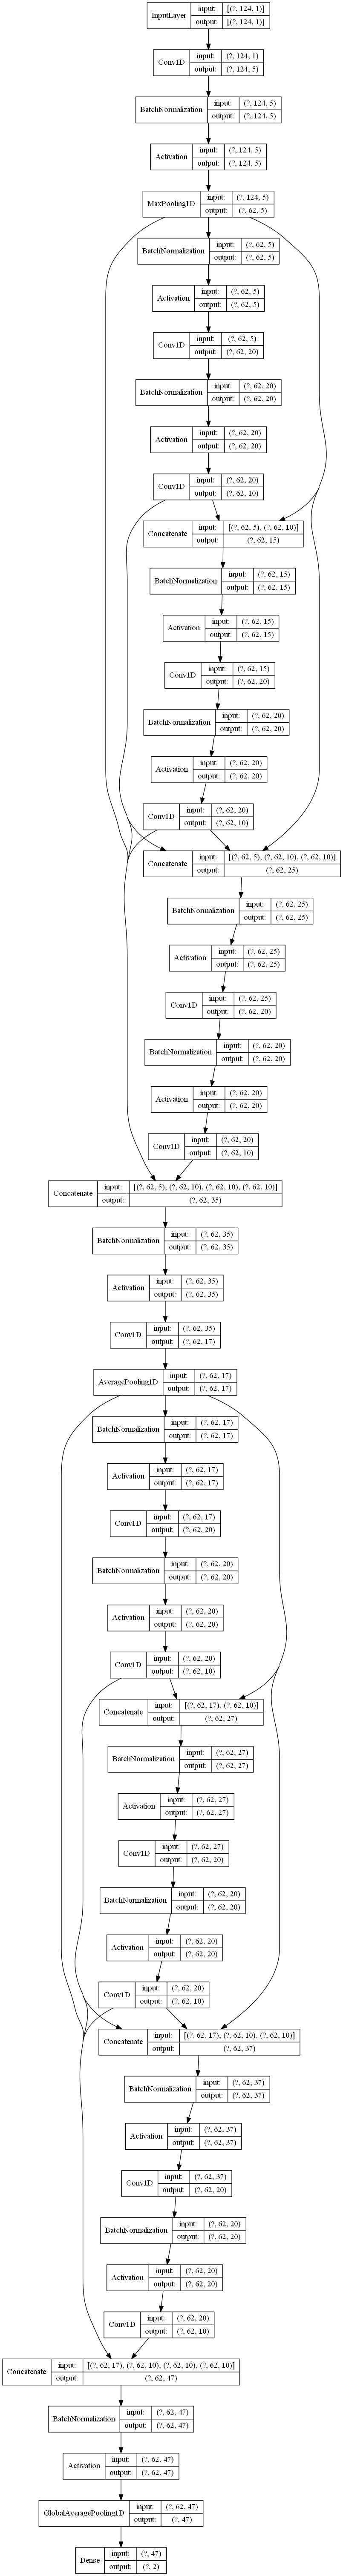

In [36]:
tf.keras.utils.plot_model(model_dense, to_file='model_dense_3_2.png', 
                          show_shapes=True, show_layer_names=False, rankdir='TB')

In [37]:
# здесь батчсайз и class_w надо указывать тот, который получился по гридсерч сетке
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.05)

In [38]:
VERBOSE = 2 # формат вывода логов обучения
BATCH_SIZE = 512
NB_EPOCH = 200 # максимальное количество эпох, если не отработает EarlyStopping
class_weighting = {0:0.05 , 1:1} #{0:0.00163 , 1:1} можно подбирать как гипер.параметр.

with tf.device('/GPU:0'):
    history_logs = model_dense.fit_generator(generator=training_generator,
                    validation_data= (X_2_2, Y_test_2) , #validation_generator,
                   #use_multiprocessing=True, 
                                     epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                     callbacks=[_time , EarlyStopping(monitor='val_loss', patience=20)])

Instructions for updating:
Please use Model.fit, which supports generators.
train_begin | time:  11.05.2021 11:45:15
Epoch 1/200
epoch_end | time:  11.05.2021 12:40:45
2945/2945 - 3325s - loss: 0.0087 - accuracy: 0.9697 - auc: 0.9948 - precision: 0.9697 - recall: 0.9697 - val_loss: 0.0421 - val_accuracy: 0.9861 - val_auc: 0.9989 - val_precision: 0.9861 - val_recall: 0.9861
Epoch 2/200
epoch_end | time:  11.05.2021 13:35:15
2945/2945 - 3269s - loss: 0.0060 - accuracy: 0.9825 - auc: 0.9976 - precision: 0.9825 - recall: 0.9825 - val_loss: 0.1275 - val_accuracy: 0.9578 - val_auc: 0.9888 - val_precision: 0.9578 - val_recall: 0.9578
Epoch 3/200
epoch_end | time:  11.05.2021 14:25:58
2945/2945 - 3042s - loss: 0.0055 - accuracy: 0.9844 - auc: 0.9980 - precision: 0.9844 - recall: 0.9844 - val_loss: 0.1210 - val_accuracy: 0.9576 - val_auc: 0.9901 - val_precision: 0.9576 - val_recall: 0.9576
Epoch 4/200
epoch_end | time:  11.05.2021 15:18:22
2945/2945 - 3142s - loss: 0.0052 - accuracy: 0.9856 - a

Epoch 32/200
epoch_end | time:  12.05.2021 15:03:15
2945/2945 - 2494s - loss: 0.0032 - accuracy: 0.9893 - auc: 0.9993 - precision: 0.9893 - recall: 0.9893 - val_loss: 0.0311 - val_accuracy: 0.9900 - val_auc: 0.9991 - val_precision: 0.9900 - val_recall: 0.9900
Epoch 33/200
epoch_end | time:  12.05.2021 15:44:47
2945/2945 - 2492s - loss: 0.0032 - accuracy: 0.9894 - auc: 0.9993 - precision: 0.9894 - recall: 0.9894 - val_loss: 0.0319 - val_accuracy: 0.9905 - val_auc: 0.9989 - val_precision: 0.9905 - val_recall: 0.9905
Epoch 34/200
epoch_end | time:  12.05.2021 16:26:51
2945/2945 - 2523s - loss: 0.0032 - accuracy: 0.9892 - auc: 0.9993 - precision: 0.9892 - recall: 0.9892 - val_loss: 0.0183 - val_accuracy: 0.9954 - val_auc: 0.9993 - val_precision: 0.9954 - val_recall: 0.9954
Epoch 35/200
epoch_end | time:  12.05.2021 17:09:06
2945/2945 - 2534s - loss: 0.0032 - accuracy: 0.9895 - auc: 0.9993 - precision: 0.9895 - recall: 0.9895 - val_loss: 0.0244 - val_accuracy: 0.9937 - val_auc: 0.9993 - val

In [39]:
res_model_dense_3_3 = pd.DataFrame(history_logs.history, columns = history_logs.history.keys())
model_dense.save('model_dense_3_3_wo_B_tests' + '.h5')
res_model_dense_3_3.to_csv('model_dense_3_3_wo_B_tests' + '.csv')

In [43]:
predict_class_val = model_dense.predict(X_3_2)
APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_test, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.05907837081957137, 0.9213772444860421, 0.8427544889720842)

In [44]:
predict_class_val = model_dense.predict(X_2_2)
APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_val, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.0625056441625695, 0.9358815518792747, 0.8717631037585494)

# DenseNet-8

In [45]:
# Гридсерч сетку настроить:
# k = {5, 10}
# initial_filters = {5, 10}, # количество фильтров лучше взять 5-10-20 (64 - из 2D)
# block_sizes = [3, 3] - для Spider-6; [4, 4] - для Spider-8
# conv_kernel_width = w, где for w in [5, 6] 
# bottleneck_size=2, лучше взять 2-3(общая формула Х = initial_filters + k * bottleneck_size (k={0,n}))
# transition_pool_size=2,
# transition_pool_stride=2, # здесь лучше поставить страйд = 1 (2 - из 2D наверно)
# theta=0.5, # это параметр для баттлнек сверток 1х1, настроить парочку из списка: {0.4, 0.5, 0.6, 1}
# initial_conv_width=5,  # здесь лучше поставить 5 (7 - для 2D)
# initial_stride=2, # здесь лучше 1 взять (2 - из 2D)
# initial_pool_width=3, # этот пулинг лучше 2 взять (3 - из 2D)
# initial_pool_stride=2  # здесь лучше поставить страйд = 1, а то размерность будет быстро уменьшаться


n_features = 124
model_dense = DenseNetCustom(input_shape = (124, 1),
                             num_outputs=2,
                             block_sizes= [4, 4],  # DenseNet-8
                             initial_filters=5,
                             k=5, 
                             conv_kernel_width=3,
                             bottleneck_size=2,
                             transition_pool_stride=1,
                             theta=0.5,
                             initial_conv_width=5,
                             initial_stride=1,
                             initial_pool_width=2,
                             initial_pool_stride=2)

In [46]:
model_dense.compile(loss='categorical_crossentropy', #optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              #optimizer='adam', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_dense.summary()

Model: "dense_net_custom_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 124, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 124, 5)       30          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 124, 5)       20          conv1d_14[0][0]                  
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 124, 5)       0           batch_normalization_15[0][0]     
_________________________________________________________________________________

In [47]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

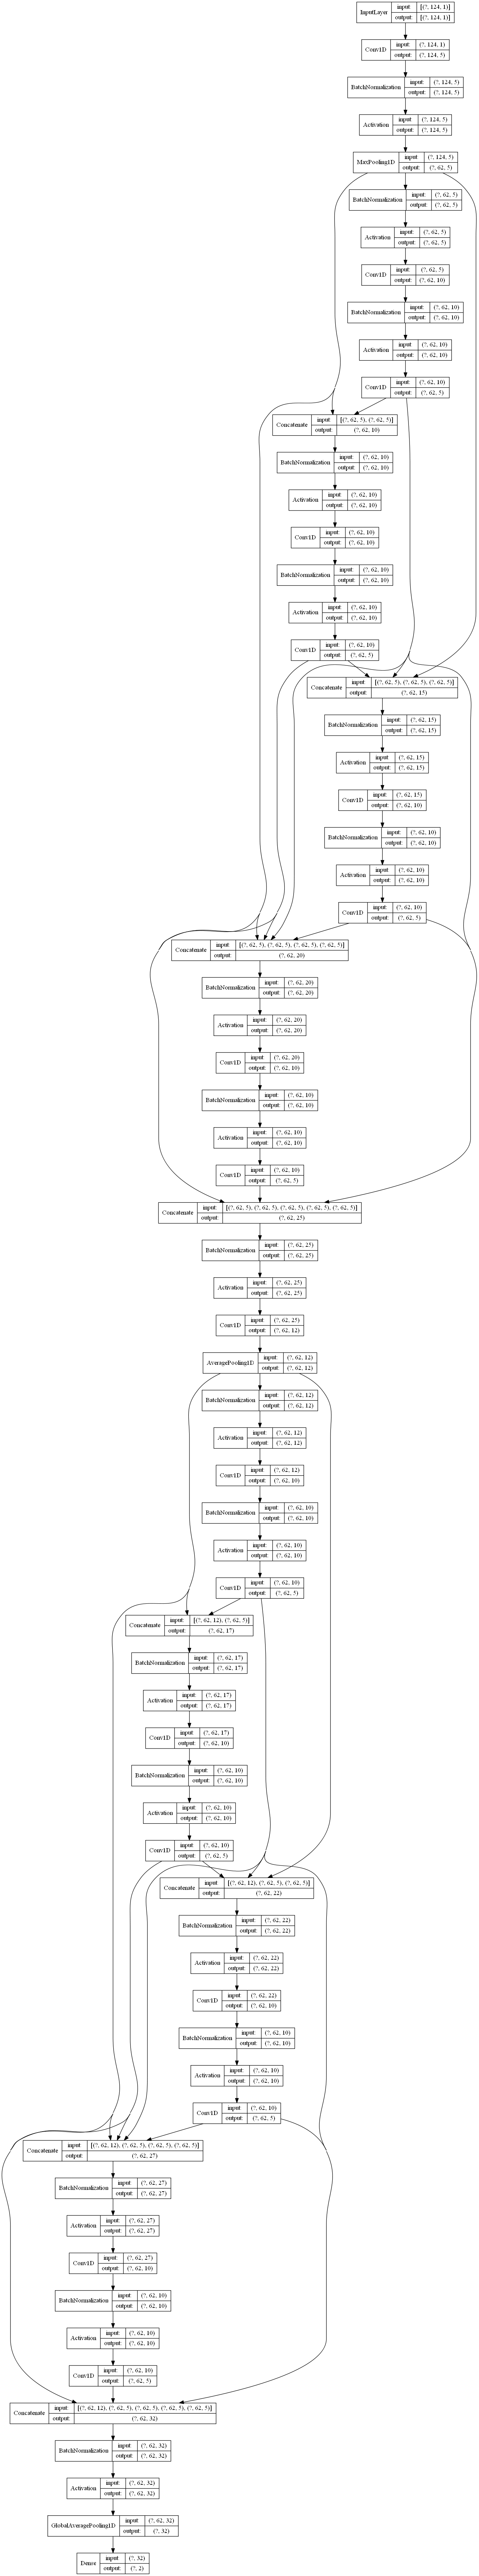

In [48]:
tf.keras.utils.plot_model(model_dense, to_file='model_dense_3_2.png', 
                          show_shapes=True, show_layer_names=False, rankdir='TB')

In [49]:
# здесь батчсайз и class_w надо указывать тот, который получился по гридсерч сетке
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.05)

In [50]:
VERBOSE = 2 # формат вывода логов обучения
BATCH_SIZE = 512
NB_EPOCH = 200 # максимальное количество эпох, если не отработает EarlyStopping
class_weighting = {0:0.05 , 1:1} #{0:0.00163 , 1:1} можно подбирать как гипер.параметр.

with tf.device('/GPU:0'):
    history_logs = model_dense.fit_generator(generator=training_generator,
                    validation_data= (X_2_2, Y_test_2) , #validation_generator,
                   #use_multiprocessing=True, 
                                     epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                     callbacks=[_time , EarlyStopping(monitor='val_loss', patience=20)])

train_begin | time:  12.05.2021 23:03:11
Epoch 1/200
epoch_end | time:  12.05.2021 23:33:10
2945/2945 - 1794s - loss: 0.0111 - accuracy: 0.9600 - auc_1: 0.9915 - precision_1: 0.9600 - recall_1: 0.9600 - val_loss: 0.0493 - val_accuracy: 0.9828 - val_auc_1: 0.9980 - val_precision_1: 0.9828 - val_recall_1: 0.9828
Epoch 2/200
epoch_end | time:  13.05.2021 00:04:01
2945/2945 - 1849s - loss: 0.0078 - accuracy: 0.9749 - auc_1: 0.9961 - precision_1: 0.9749 - recall_1: 0.9749 - val_loss: 0.1294 - val_accuracy: 0.9542 - val_auc_1: 0.9886 - val_precision_1: 0.9542 - val_recall_1: 0.9542
Epoch 3/200
epoch_end | time:  13.05.2021 00:34:20
2945/2945 - 1819s - loss: 0.0070 - accuracy: 0.9786 - auc_1: 0.9970 - precision_1: 0.9786 - recall_1: 0.9786 - val_loss: 0.0504 - val_accuracy: 0.9823 - val_auc_1: 0.9979 - val_precision_1: 0.9823 - val_recall_1: 0.9823
Epoch 4/200
epoch_end | time:  13.05.2021 01:04:46
2945/2945 - 1825s - loss: 0.0066 - accuracy: 0.9801 - auc_1: 0.9974 - precision_1: 0.9801 - rec

epoch_end | time:  13.05.2021 15:22:13
2945/2945 - 2017s - loss: 0.0046 - accuracy: 0.9871 - auc_1: 0.9988 - precision_1: 0.9871 - recall_1: 0.9871 - val_loss: 0.0411 - val_accuracy: 0.9877 - val_auc_1: 0.9986 - val_precision_1: 0.9877 - val_recall_1: 0.9877


In [51]:
res_model_dense_3_3 = pd.DataFrame(history_logs.history, columns = history_logs.history.keys())
model_dense.save('model_dense_4_4_wo_B_tests' + '.h5')
res_model_dense_3_3.to_csv('model_dense_4_4_wo_B_tests' + '.csv')

In [52]:
predict_class_val = model_dense.predict(X_3_2)
APS = metrics.average_precision_score(y_test, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_test, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.04913416418666367, 0.9347045864646114, 0.8694091729292228)

In [53]:
predict_class_val = model_dense.predict(X_2_2)
APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
AUC = metrics.roc_auc_score(y_val, predict_class_val[:,1])
GINI = 2*AUC - 1
APS, AUC, GINI

(0.054383696557835606, 0.9317478696063843, 0.8634957392127687)